In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import csv

import tensorflow as tf
import keras
from keras import backend as K
#print(K.image_data_format())
K.set_image_data_format('channels_first')

from keras.models import Model
from keras.layers import Input, Dense
from keras.models import load_model

from tables import *

import collections
from PIL import Image
import os

from utils.data.load_data import get_UKB_dataset
from utils.params import TRAIN_RATIO, VAL_RATIO
from utils.data.preprocessing_utils import load_ukb_fundus_img
from utils.data.preprocess import get_preprocess_fn

In [3]:
bagnet33_model_path = 'UKB_genderNet_bagnet33_imagenet_098_0.835.hdf5'
channel_first = True
dnn_type='bagnet33'
model_dir = '/gpfs01/berens/user/iilanchezian/Projects/UKbiobank/supervised/modelstore/%s/' % (dnn_type)
model_path = os.path.join(model_dir, bagnet33_model_path)

bagnet = load_model(model_path)
print('========================================================================')
print('BagNet')
bagnet.summary()
print('========================================================================')

# feature extractor 
feature_extractor = Model(inputs=bagnet.input, outputs=bagnet.get_layer('layer4.2.relu0.23004603898000509').output)
for layer in feature_extractor.layers:
    layer.trainable = False
print('========================================================================')
print('Feature Extractor')
feature_extractor.summary()
print('========================================================================')

feature_vector = Input(shape=(2048,))
logits = bagnet.get_layer('dense_1')(feature_vector)
softmax = bagnet.get_layer('activation_1')(logits)

logit_machine = Model(inputs=feature_vector, outputs=logits)
for layer in logit_machine.layers:
    layer.trainable = False
print('========================================================================')
print('Logit Machine')
logit_machine.summary()
print('========================================================================')

lin_classifier = Model(inputs=feature_vector, outputs=softmax)
for layer in lin_classifier.layers:
    layer.trainable = False
print('========================================================================')    
print('Linear Classifier')
lin_classifier.summary()
print('========================================================================')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

BagNet
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input0 (InputLayer)             (None, 3, 224, 224)  0                                            
__________________________________________________________________________________________________
conv10.275406533888118 (Conv2D) (None, 64, 224, 224) 192         input0[0][0]                     
__________________________________________________________________________________________________
conv20.7357471192702366 (Conv2D (None, 64, 222, 222) 36864       conv10.275406533888118[0][0]     
__________________________________________________________________________________________________
bn10.3729843759042565 (BatchNor (None, 64, 222, 222) 256         conv20.7357471192702366[

In [4]:
# def filter_patches(h5filename, qual_threshold, condition):
#     h5file = open_file(h5filename)
#     patch_table = h5file.root.patch.patchinfo
#     patch_info = [patch['filename'] for patch in 
#                patch_table.where(condition)]
#     print('Done')
#     return patch_info

# quality_threshold = 0.5

# img_dir = '/gpfs01/berens/data/data/biobank/ukb_fundus_224/'
# storage_dir = '/gpfs01/berens/user/iilanchezian/Projects/UKbiobank/supervised/patch_features/'
# train_fname = os.path.join(storage_dir, 'bagnet33_patch_attributes_and_features_train_v4.h5')
# val_fname = os.path.join(storage_dir, 'bagnet33_patch_attributes_and_features_val_v4.h5')
# test_fname = os.path.join(storage_dir, 'bagnet33_patch_attributes_and_features_test_v4.h5')

# condition1 = """(global_quality < qual_threshold) & (true_label == 0) & (predicted_label == true_label)"""
# condition2 = """(global_quality < qual_threshold) & (true_label == 1) & (predicted_label == true_label)"""

# %time female_patches = filter_patches(test_fname, quality_threshold, condition1)
# %time male_patches = filter_patches(test_fname, quality_threshold, condition2)

# np.save('patch_data/bg33_test_patches_female.npy', np.unique(female_patches))
# np.save('patch_data/bg33_test_patches_male.npy', np.unique(male_patches))

Done
CPU times: user 3.64 s, sys: 2.29 s, total: 5.93 s
Wall time: 23.2 s
Done
CPU times: user 2.93 s, sys: 2.1 s, total: 5.04 s
Wall time: 12.4 s


In [ ]:
female_patches = np.load('patch_data/bg33_test_patches_female.npy')
male_patches = np.load('patch_data/bg33_test_patches_male.npy')

In [5]:
female_patches = np.unique(female_patches)
print('Total female fundus images: %d'%(len(female_patches)))
female_left_patches = [patch for patch in female_patches if b'21015' in patch]
print('Female fundus images of left eye: %d'%(len(female_left_patches)))
female_right_patches = [patch for patch in female_patches if b'21016' in patch]
print('Female fundus images of right eye: %d'%(len(female_right_patches)))

male_patches = np.unique(male_patches)
print('Total male fundus images: %d'%(len(male_patches)))
male_left_patches = [patch for patch in male_patches if b'21015' in patch]
print('Male fundus images of left eye: %d'%(len(male_left_patches)))
male_right_patches = [patch for patch in male_patches if b'21016' in patch]
print('Male fundus images of right eye: %d'%(len(male_right_patches)))

Total female fundus images: 3310
Female fundus images of left eye: 1598
Female fundus images of right eye: 1713
Total male fundus images: 2779
Male fundus images of left eye: 1296
Male fundus images of right eye: 1483


In [6]:
def get_logits(patches):
    dnn_type='bagnet33'
    preprocess_fn = get_preprocess_fn(dnn_type)
    
    logits_all = []
    
    for patch in patches:
        filename = patch.decode("utf-8")
        path = os.path.join(img_dir, filename)
        with Image.open(path) as img:
            img = np.asarray(img, dtype=np.int32)
        
        img_proc = load_ukb_fundus_img(path=path, data_aug=None, mask=True, 
                                       subtract_bg=False, kernel='median',
                                       ksize=23, channel_first=True,
                                       preprocessing_function=preprocess_fn)
        
        features = feature_extractor.predict(img_proc)[0]
        my_batch = np.transpose(np.reshape(features, newshape=(features.shape[0], -1)))
        
        logits = logit_machine.predict(my_batch)#[:,gender_idx]
#         heatmap = np.reshape(heatmap, newshape=(features.shape[-2],features.shape[-1]))
        
        logits_all.append(logits)

        
    logits_all = np.asarray(logits_all)
    return logits_all

In [7]:
logits_male_images = get_logits(male_patches)
logits_male_images = np.squeeze(logits_male_images)

In [8]:
logits_female_images = get_logits(female_patches)
logits_female_images = np.squeeze(logits_female_images)

In [9]:
logits_male_images_max = np.max(logits_male_images, axis=1)
logits_female_images_max = np.max(logits_female_images, axis=1)

logits_male_images_min = np.min(logits_male_images, axis=1)
logits_female_images_min = np.min(logits_female_images, axis=1)

In [10]:
n_male = logits_male_images.shape[0]
n_female = logits_female_images.shape[0]

In [14]:
def get_cohen_d(arr1, arr2):
    n1 = arr1.shape[0]
    n2 = arr2.shape[0]
    
    mean1 = np.mean(arr1)
    mean2 = np.mean(arr2)
    
    std1 = np.std(arr1)
    std2 = np.std(arr2)
    
    std1_2 = std1 ** 2
    std2_2 = std2 ** 2
    
    weighted_std = (n1 * std1_2) + (n2 * std2_2)
    pooled_std = np.sqrt(weighted_std / (n1+n2))
    
    cohen_d = np.abs(mean1 - mean2) / pooled_std
    
    return cohen_d

In [15]:
thresh = 50
num_patches = 576

male_patch_fractions_male_images = np.sum(logits_male_images > thresh, axis=1)/num_patches
male_patch_fractions_female_images = np.sum(logits_female_images > thresh, axis=1)/num_patches

d_prime_male_frac = get_cohen_d(male_patch_fractions_male_images, male_patch_fractions_female_images)
print(d_prime_male_frac)

d_prime_male_logits = get_cohen_d(logits_male_images_max, logits_female_images_max)
print(d_prime_male_logits)

1.8223233080170962
0.7743611005110859


In [16]:
thresh = -50

female_patch_fractions_male_images = np.sum(logits_male_images < thresh, axis=1)/576
female_patch_fractions_female_images = np.sum(logits_female_images < thresh, axis=1)/576

d_prime_female_frac = get_cohen_d(female_patch_fractions_male_images, female_patch_fractions_female_images)
print(d_prime_female_frac)

d_prime_female_logits = get_cohen_d(logits_male_images_min, logits_female_images_min)
print(d_prime_female_logits)

1.6317900307088893
0.7577674412749182


In [17]:
male_fractions = np.concatenate([male_patch_fractions_male_images, male_patch_fractions_female_images])
max_logits = np.concatenate([logits_male_images_max, logits_female_images_max])

female_fractions = np.concatenate([female_patch_fractions_male_images, female_patch_fractions_female_images])
min_logits = np.concatenate([-1*logits_male_images_min, -1*logits_female_images_min])

In [18]:
male = ['Male'] * len(logits_male_images_max)
female = ['Female'] * len(logits_female_images_max)

gender = np.concatenate([male, female])
d_male = {'Fractions': male_fractions, 'Logits': max_logits, 'Gender':gender}
d_female = {'Fractions': female_fractions, 'Logits': min_logits, 'Gender':gender}
df_male = pd.DataFrame(data=d_male)
df_female = pd.DataFrame(data=d_female)

In [19]:
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

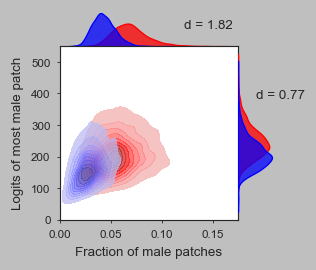

In [20]:
from matplotlib.lines import Line2D

def set_rcParams():
    sns.set_context('paper')
    sns.set_style('ticks')
    plt.rcParams['axes.linewidth']    = .7
    plt.rcParams['xtick.major.width'] = .5
    plt.rcParams['ytick.major.width'] = .5
    plt.rcParams['xtick.minor.width'] = .5
    plt.rcParams['ytick.minor.width'] = .5
    plt.rcParams['xtick.major.size'] = 2
    plt.rcParams['ytick.major.size'] = 2
    plt.rcParams['xtick.minor.size'] = 1
    plt.rcParams['ytick.minor.size'] = 1
    plt.rcParams['font.size']       = 8
    plt.rcParams['axes.titlesize']  = 10 
    plt.rcParams['axes.labelsize']  = 8
    plt.rcParams['legend.fontsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['figure.facecolor']=(0.5,0.5,0.5,0.5) # only affects the notebook
    plt.rcParams['savefig.facecolor']=(1,1,1,0)
    plt.rcParams["savefig.dpi"] = 1200
    plt.rcParams['font.family'] = "Arial"
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams['figure.dpi'] = 120     # only affects the notebook
set_rcParams()


fig, axs=plt.subplots(2,2,figsize=(2.3,2.3), gridspec_kw={'hspace': 0, 
                                                        'wspace': 0,
                                                        'width_ratios': [5, 1],
                                                        'height_ratios': [1, 5]})

# Upper part charts
sns.kdeplot(x=df_male[df_male['Gender']=="Male"].Fractions, ax=axs[0,0], color="red", fill=True, alpha=0.75)
sns.kdeplot(x=df_male[df_male['Gender']=="Female"].Fractions, ax=axs[0,0], color="blue", fill=True, alpha=0.75)
axs[0,0].text(0.7, 0.5, 'd = %.2f'%d_prime_male_frac, transform=axs[0,0].transAxes)


axs[0,0].axis("off")
axs[0,1].axis("off")
axs[1,1].axis("off")

# Right part charts
sns.kdeplot(y=df_male[df_male['Gender']=="Male"].Logits, ax=axs[1,1], color="red", fill=True, alpha=0.75)
sns.kdeplot(y=df_male[df_male['Gender']=="Female"].Logits, ax=axs[1,1], color="blue", fill=True, alpha=0.75)
axs[1,1].text(0.5, 0.7, 'd = %.2f'%d_prime_male_logits, transform=axs[1,1].transAxes)

# KDE middle part
sns.kdeplot(x=df_male[df_male['Gender']=="Male"].Fractions, y=df_male[df_male['Gender']=="Male"].Logits, 
            fill=True, color="r", ax=axs[1,0], alpha=0.75)
sns.kdeplot(x=df_male[df_male['Gender']=="Female"].Fractions, y=df_male[df_male['Gender']=="Female"].Logits, 
            fill=True, color="b", ax=axs[1,0], alpha=0.75)

axs[1,0].set_xlabel('Fraction of male patches')
axs[1,0].set_ylabel('Logits of most male patch')
axs[1,0].set_ylim(0, 550)
axs[1,0].set_yticks([0,100,200,300,400,500])
axs[1,0].set_xlim(0, 0.175)
axs[1,0].set_xticks([0.00, 0.05, 0.10, 0.15])

# main_palette_colors = ['r', 'b']
# classes = ['Male', 'Female']
# c = [Line2D([0], [0], marker='o', color=main_palette_colors[idx], linewidth=0,
#                         markerfacecolor=main_palette_colors[idx], markersize=5) for idx in range(len(classes))]
# axs[1,0].legend(handles=c, labels=classes, bbox_to_anchor=(0.97, 0.98), loc='upper right', borderaxespad=0.)

plt.savefig('male_jointplot.pdf', dpi=600, bbox_inches='tight')

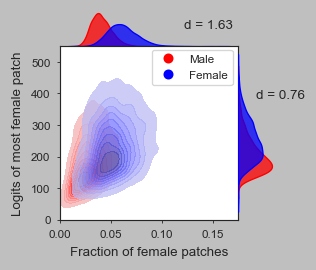

In [22]:
fig, axs=plt.subplots(2,2,figsize=(2.3,2.3), gridspec_kw={'hspace': 0, 
                                                        'wspace': 0,
                                                        'width_ratios': [5, 1],
                                                        'height_ratios': [1, 5]})

# Upper part charts
sns.kdeplot(x=df_female[df_female['Gender']=="Male"].Fractions, ax=axs[0,0], color="red", fill=True, alpha=0.75)
sns.kdeplot(x=df_female[df_female['Gender']=="Female"].Fractions, ax=axs[0,0], color="blue", fill=True, alpha=0.75)

axs[0,0].axis("off")
axs[0,1].axis("off")
axs[1,1].axis("off")

# Right part charts
sns.kdeplot(y=df_female[df_female['Gender']=="Male"].Logits, ax=axs[1,1], color="red", fill=True, alpha=0.75)
sns.kdeplot(y=df_female[df_female['Gender']=="Female"].Logits, ax=axs[1,1], color="blue", fill=True, alpha=0.75)
axs[0,0].text(0.7, 0.5, 'd = %.2f'%d_prime_female_frac, transform=axs[0,0].transAxes)

# KDE middle part
sns.kdeplot(x=df_female[df_female['Gender']=="Male"].Fractions, y=df_female[df_female['Gender']=="Male"].Logits, 
            fill=True, color="r", ax=axs[1,0], alpha=0.75)
sns.kdeplot(x=df_female[df_female['Gender']=="Female"].Fractions, y=df_female[df_female['Gender']=="Female"].Logits, 
            fill=True, color="b", ax=axs[1,0], alpha=0.75)
axs[1,1].text(0.5, 0.7, 'd = %.2f'%d_prime_female_logits, transform=axs[1,1].transAxes)


axs[1,0].set_xlabel('Fraction of female patches')
axs[1,0].set_ylabel('Logits of most female patch')

axs[1,0].set_ylim(0, 550)
axs[1,0].set_yticks([0,100,200,300,400,500])
axs[1,0].set_xlim(0, 0.175)
axs[1,0].set_xticks([0.00, 0.05, 0.10, 0.15])

main_palette_colors = ['r', 'b']
classes = ['Male', 'Female']
c = [Line2D([0], [0], marker='o', color=main_palette_colors[idx], linewidth=0,
                        markerfacecolor=main_palette_colors[idx], markersize=5) for idx in range(len(classes))]
axs[1,0].legend(handles=c, labels=classes, bbox_to_anchor=(0.97, 0.98), loc='upper right', borderaxespad=0.)
plt.savefig('female_jointplot.pdf', dpi=600, bbox_inches='tight')